In [1]:
from BinaryNet.utils.ClassificationTrainer import ClassificationTrainer
from BinaryNet.utils.Dataset import SCWithFeatures, FilteredSubsetSC, TARGET_WORDS
from BinaryNet.utils.SoundUtils import prepareMelSpectrogram

import os

c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  warnings.warn(


In [2]:
DATA_DIR = os.path.abspath('../data')
SPEECHCOMMANDS_DATASET_PATH = os.path.join(DATA_DIR, "SPEECHCOMMANDS")

class_counts = len(TARGET_WORDS)
train = SCWithFeatures(FilteredSubsetSC(SPEECHCOMMANDS_DATASET_PATH, "training", TARGET_WORDS), prepareMelSpectrogram)
val   = SCWithFeatures(FilteredSubsetSC(SPEECHCOMMANDS_DATASET_PATH, "validation", TARGET_WORDS), prepareMelSpectrogram)

trainer = ClassificationTrainer(train, val)

## Наивная реализация XNOR Net из статьи

https://arxiv.org/pdf/1603.05279 XNOR-Net: ImageNet Classification Using Binary Convolutional Neural Networks


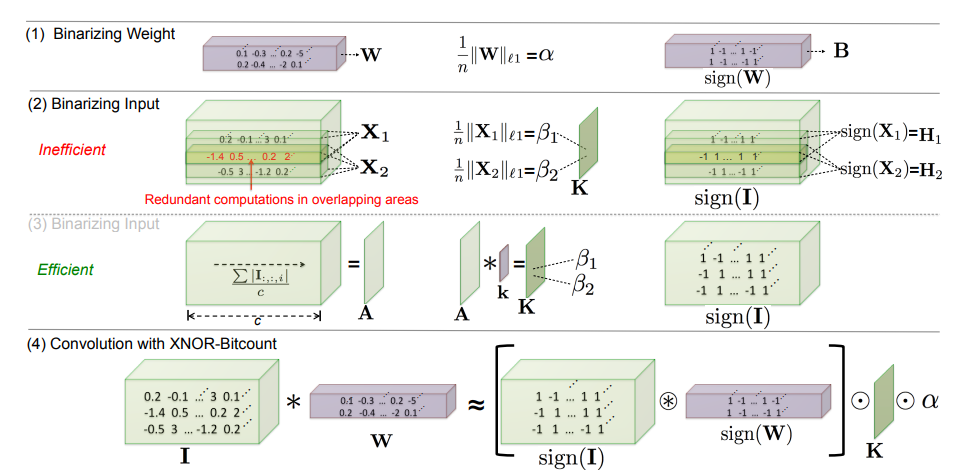

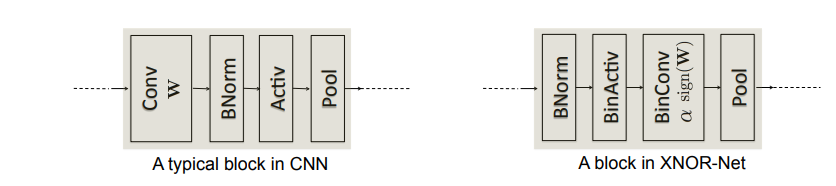

In [3]:
import torch
import torch.nn as nn

class SignSTE(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        ctx.save_for_backward(x)
        return x.sign()
    @staticmethod
    def backward(ctx, g):
        (x,) = ctx.saved_tensors
        mask = (x.abs() <= 1).to(g.dtype)
        return g * mask

class NaiveXNORLinear(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(NaiveXNORLinear, self).__init__()
        self.fc = nn.Linear(ch_in, ch_out, bias=True)

    def forward(self, input_x):
        quantized_weight = SignSTE.apply(self.fc.weight)
        quintized_input = SignSTE.apply(input_x)
        out = nn.functional.linear(quintized_input, quantized_weight)
        alpha = self.fc.weight.abs().mean()
        betta = input_x.abs().mean()
        return out*alpha*betta + self.fc.bias
    
class NaiveXNORConv2d(nn.Module):
    def __init__(self, ch_in,ch_out, kernel=3, padding=0, stride=1):
        super(NaiveXNORConv2d, self).__init__()
        self.padding = padding
        self.stride = stride
        self.conv = nn.Conv2d(ch_in, ch_out, kernel, stride, padding, bias=False)
        k = torch.ones((1, 1, kernel, kernel))/(kernel**2) #< Now consider only constants
        self.k = nn.parameter.Buffer(k, persistent=False)

    def forward(self, input_x):
        # A, k - BinActiv
        A = input_x.abs().mean(axis=1, keepdim=True)
        K = nn.functional.conv2d(A, self.k, None, self.stride, self.padding)
        alpha = self.conv.weight.abs().mean()

        quantized_weight = SignSTE.apply(self.conv.weight)
        quintized_input = SignSTE.apply(input_x)
        out = nn.functional.conv2d(quintized_input, quantized_weight, None, self.stride, self.padding)
        return out*K*alpha
    
class NaiveXNORSimpleCNN(torch.nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Conv2d(1, 64, (5,5), padding=2),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d((2,2), stride=2),
            torch.nn.BatchNorm2d(64),
            NaiveXNORConv2d(64, 96, 3, padding=1),
            torch.nn.MaxPool2d((2,2), stride=2),
            torch.nn.BatchNorm2d(96),
            NaiveXNORConv2d(96, 128, 3, padding=1),
            torch.nn.BatchNorm2d(128),
            NaiveXNORConv2d(128, 256, 3, padding=1),
            torch.nn.AdaptiveAvgPool2d((1,1)),
            torch.nn.Flatten()
        )
        self.fc = torch.nn.Sequential(
            NaiveXNORLinear(256, 64),
            torch.nn.Linear(64, n_classes)
        )
        
    def forward(self, x):
        z = self.net(x)
        return self.fc(z)

In [4]:
SIMPLECNN_DIR = os.path.abspath('./models/NaiveXNORSimpleCNN')
SIMPLECNN_CHECKPOINTS_DIR = os.path.join(SIMPLECNN_DIR, 'checkpoints')
os.makedirs(SIMPLECNN_CHECKPOINTS_DIR, exist_ok=True)

model = trainer.fit(20, NaiveXNORSimpleCNN(class_counts), bs_test=512, save_path=SIMPLECNN_CHECKPOINTS_DIR)

100%|██████████| 241/241 [00:48<00:00,  4.94it/s]


epoch - 0: loss = 1.7140538692474365, f1 = 0.35446628114340295


100%|██████████| 241/241 [00:48<00:00,  5.02it/s]


epoch - 1: loss = 2.0882980823516846, f1 = 0.3762998054185398


100%|██████████| 241/241 [00:48<00:00,  5.02it/s]


epoch - 2: loss = 1.15699303150177, f1 = 0.592184065704842


100%|██████████| 241/241 [00:48<00:00,  5.01it/s]


epoch - 3: loss = 1.144796371459961, f1 = 0.6126507983450576


100%|██████████| 241/241 [00:48<00:00,  5.01it/s]


epoch - 4: loss = 1.2484111785888672, f1 = 0.6148854744393282


100%|██████████| 241/241 [00:48<00:00,  5.02it/s]


epoch - 5: loss = 1.236332893371582, f1 = 0.578859286404416


100%|██████████| 241/241 [00:48<00:00,  5.01it/s]


epoch - 6: loss = 0.8995672464370728, f1 = 0.704760419866529


100%|██████████| 241/241 [00:48<00:00,  4.98it/s]


epoch - 7: loss = 0.8316935300827026, f1 = 0.7198929613804137


100%|██████████| 241/241 [00:48<00:00,  4.98it/s]


epoch - 8: loss = 0.7448375225067139, f1 = 0.7469818266701768


100%|██████████| 241/241 [00:48<00:00,  4.98it/s]


epoch - 9: loss = 0.7797011733055115, f1 = 0.7253779859175752


100%|██████████| 241/241 [00:48<00:00,  4.98it/s]


epoch - 10: loss = 0.7911753058433533, f1 = 0.722274133532876


100%|██████████| 241/241 [00:48<00:00,  4.98it/s]


epoch - 11: loss = 0.7905802726745605, f1 = 0.7311031279912081


100%|██████████| 241/241 [00:48<00:00,  4.98it/s]


epoch - 12: loss = 0.6790679097175598, f1 = 0.7808206678314473


100%|██████████| 241/241 [00:48<00:00,  4.98it/s]


epoch - 13: loss = 0.646415114402771, f1 = 0.7961915148280732


100%|██████████| 241/241 [00:48<00:00,  4.98it/s]


epoch - 14: loss = 0.714748740196228, f1 = 0.7666809972321545


100%|██████████| 241/241 [00:48<00:00,  4.99it/s]


epoch - 15: loss = 0.8580842614173889, f1 = 0.7251156856727862


100%|██████████| 241/241 [00:48<00:00,  4.97it/s]


epoch - 16: loss = 0.9187654256820679, f1 = 0.6767703127355295


100%|██████████| 241/241 [00:48<00:00,  4.98it/s]


epoch - 17: loss = 0.9161159992218018, f1 = 0.6898723090729029


100%|██████████| 241/241 [00:48<00:00,  4.98it/s]


epoch - 18: loss = 0.7517643570899963, f1 = 0.7337451348102114


100%|██████████| 241/241 [00:48<00:00,  4.98it/s]


epoch - 19: loss = 0.6146178245544434, f1 = 0.7928978608032473


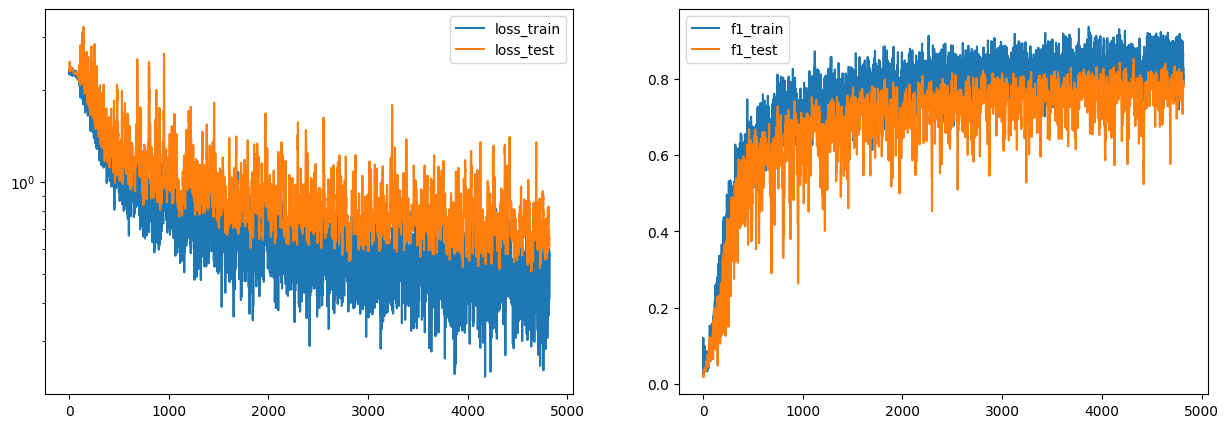

In [5]:
trainer.visualize(filename=os.path.join(SIMPLECNN_DIR, "learning.jpg"))

In [6]:
class NaiveXNORLinearImproved(nn.Module):
    def __init__(self, ch_in, ch_out):
        super().__init__()
        self.fc = nn.Linear(ch_in, ch_out, bias=True)

    def forward(self, x):
        w_bin = SignSTE.apply(self.fc.weight)
        x_bin = SignSTE.apply(x)
        y = nn.functional.linear(x_bin, w_bin, bias=None)
        alpha = self.fc.weight.abs().mean(dim=1, keepdim=True).t()
        beta  = x.abs().mean(dim=1, keepdim=True)
        y = y * alpha.view(1, -1) * beta
        return y + self.fc.bias
    
class NaiveXNORConv2dImproved(nn.Module):
    def __init__(self, ch_in,ch_out, kernel=3, padding=0, stride=1):
        super().__init__()
        self.padding = padding
        self.stride = stride
        self.conv = nn.Conv2d(ch_in, ch_out, kernel, stride, padding, bias=False)
        k = torch.ones((1, 1, kernel, kernel))/(kernel**2) #< Now consider only constants
        self.k = nn.parameter.Buffer(k, persistent=False)

    def forward(self, input_x):
        # A, k - BinActiv
        A = input_x.abs().mean(axis=1, keepdim=True)
        K = nn.functional.conv2d(A, self.k, None, self.stride, self.padding)

        w_bin = SignSTE.apply(self.conv.weight)
        x_bin = SignSTE.apply(input_x)
        out = nn.functional.conv2d(x_bin, w_bin, None, self.stride, self.padding)

        alpha = self.conv.weight.abs().mean(dim=(1,2,3), keepdim=True) # [out,1,1,1]
        return out * alpha.view(1, -1, 1, 1) * K 
    
class NaiveXNORSimpleCNNImproved(torch.nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Conv2d(1, 64, (5,5), padding=2),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d((2,2), stride=2),
            torch.nn.BatchNorm2d(64),
            NaiveXNORConv2dImproved(64, 96, 3, padding=1),
            torch.nn.MaxPool2d((2,2), stride=2),
            torch.nn.BatchNorm2d(96),
            NaiveXNORConv2dImproved(96, 128, 3, padding=1),
            torch.nn.BatchNorm2d(128),
            NaiveXNORConv2dImproved(128, 256, 3, padding=1),
            torch.nn.AdaptiveAvgPool2d((1,1)),
            torch.nn.Flatten()
        )
        self.fc = torch.nn.Sequential(
            NaiveXNORLinearImproved(256, 64),
            torch.nn.Linear(64, n_classes)
        )
        
    def forward(self, x):
        z = self.net(x)
        return self.fc(z)

In [7]:
SIMPLECNN_DIR = os.path.abspath('./models/NaiveXNORSimpleCNNImproved')
SIMPLECNN_CHECKPOINTS_DIR = os.path.join(SIMPLECNN_DIR, 'checkpoints')
os.makedirs(SIMPLECNN_CHECKPOINTS_DIR, exist_ok=True)

model = trainer.fit(20, NaiveXNORSimpleCNNImproved(class_counts), bs_test=512, save_path=SIMPLECNN_CHECKPOINTS_DIR)

100%|██████████| 241/241 [00:48<00:00,  4.93it/s]


epoch - 0: loss = 1.8300950527191162, f1 = 0.26650351996880783


100%|██████████| 241/241 [00:48<00:00,  4.97it/s]


epoch - 1: loss = 1.2175426483154297, f1 = 0.5844910677322865


100%|██████████| 241/241 [00:48<00:00,  4.97it/s]


epoch - 2: loss = 0.8924392461776733, f1 = 0.7019480343406317


100%|██████████| 241/241 [00:48<00:00,  4.97it/s]


epoch - 3: loss = 0.8717919588088989, f1 = 0.6887319520174098


100%|██████████| 241/241 [00:48<00:00,  4.97it/s]


epoch - 4: loss = 0.9308063983917236, f1 = 0.6692555759755285


100%|██████████| 241/241 [00:48<00:00,  4.97it/s]


epoch - 5: loss = 0.8623475432395935, f1 = 0.7171180978713924


100%|██████████| 241/241 [00:48<00:00,  4.97it/s]


epoch - 6: loss = 0.6577399373054504, f1 = 0.7672276010424477


100%|██████████| 241/241 [00:48<00:00,  4.97it/s]


epoch - 7: loss = 0.7897652983665466, f1 = 0.6974035843265158


100%|██████████| 241/241 [00:48<00:00,  4.97it/s]


epoch - 8: loss = 0.5755389332771301, f1 = 0.7997288866270689


100%|██████████| 241/241 [00:48<00:00,  4.97it/s]


epoch - 9: loss = 1.4280681610107422, f1 = 0.548644432125581


100%|██████████| 241/241 [00:48<00:00,  4.97it/s]


epoch - 10: loss = 1.1865533590316772, f1 = 0.6480750708603911


100%|██████████| 241/241 [00:48<00:00,  4.97it/s]


epoch - 11: loss = 0.6340315341949463, f1 = 0.7614187589812855


100%|██████████| 241/241 [00:48<00:00,  4.97it/s]


epoch - 12: loss = 0.7281700968742371, f1 = 0.7826324363639084


100%|██████████| 241/241 [00:48<00:00,  4.96it/s]


epoch - 13: loss = 0.5337059497833252, f1 = 0.8262232898329638


100%|██████████| 241/241 [00:48<00:00,  4.97it/s]


epoch - 14: loss = 0.5818212032318115, f1 = 0.8030668829223672


100%|██████████| 241/241 [00:48<00:00,  4.97it/s]


epoch - 15: loss = 0.6304739713668823, f1 = 0.7987298595406245


100%|██████████| 241/241 [00:48<00:00,  4.97it/s]


epoch - 16: loss = 0.5619525909423828, f1 = 0.8178430840857948


100%|██████████| 241/241 [00:48<00:00,  4.97it/s]


epoch - 17: loss = 0.7906089425086975, f1 = 0.7379554984308888


100%|██████████| 241/241 [00:49<00:00,  4.89it/s]


epoch - 18: loss = 0.6077747344970703, f1 = 0.7937886850303558


100%|██████████| 241/241 [00:54<00:00,  4.44it/s]


epoch - 19: loss = 0.849779486656189, f1 = 0.7597206876115498


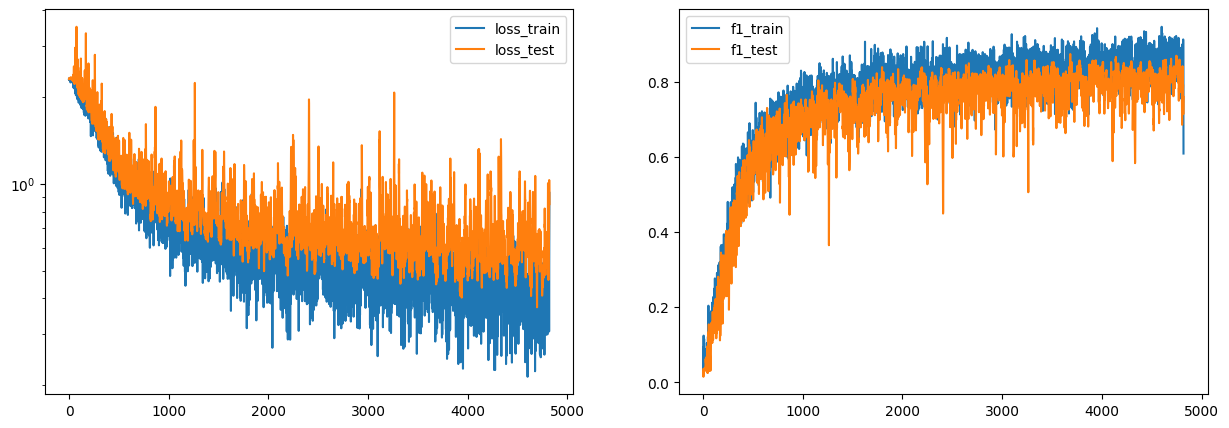

In [8]:
trainer.visualize(filename=os.path.join(SIMPLECNN_DIR, "learning.jpg"))

## Используем готовую реализацию из репозиториев

* https://github.com/allenai/XNOR-Net - оригинальный репозиторий на lua
* https://github.com/cooooorn/Pytorch-XNOR-Net
* https://github.com/jiecaoyu/XNOR-Net-PyTorch

In [3]:
from BinaryNet.binary_layers.XNORFromRepository import BinConv2d
import torch

class XNORFromRepositorySimpleCNN(torch.nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Conv2d(1, 64, (5,5), padding=2),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d((2,2), stride=2),
            BinConv2d(64, 96, (3,3), padding=1),
            torch.nn.MaxPool2d((2,2), stride=2),
            BinConv2d(96, 128, (3,3), padding=1),
            BinConv2d(128, 256, (3,3), padding=1),
            torch.nn.AdaptiveAvgPool2d((1,1)),
            torch.nn.Flatten()
        )
        self.fc = torch.nn.Sequential(
            BinConv2d(256, 64, Linear=True),
            torch.nn.Linear(64, n_classes)
        )
        
    def forward(self, x):
        z = self.net(x)
        return self.fc(z)

In [4]:
# Используем отдельный trainer, т.к. градиент и бинаризация весов реализованы отдельно от BinConv2d
from BinaryNet.utils.BinOpClassificationTrainer import BinOpClassificationTrainer
trainer_bin_op = BinOpClassificationTrainer(train, val)

In [5]:
SIMPLECNN_DIR = os.path.abspath('./models/XNORFromRepositorySimpleCNN')
SIMPLECNN_CHECKPOINTS_DIR = os.path.join(SIMPLECNN_DIR, 'checkpoints')
os.makedirs(SIMPLECNN_CHECKPOINTS_DIR, exist_ok=True)

import warnings
warnings.filterwarnings('ignore')

model = trainer_bin_op.fit(20, XNORFromRepositorySimpleCNN(class_counts), bs_test=512, save_path=SIMPLECNN_CHECKPOINTS_DIR)

100%|██████████| 241/241 [00:45<00:00,  5.30it/s]


epoch - 0: loss = 1.0981930494308472, f1 = 0.6235342337685513


100%|██████████| 241/241 [00:45<00:00,  5.33it/s]


epoch - 1: loss = 0.7359719276428223, f1 = 0.7384640470286467


100%|██████████| 241/241 [00:45<00:00,  5.27it/s]


epoch - 2: loss = 0.6055669188499451, f1 = 0.7970478180982178


100%|██████████| 241/241 [00:45<00:00,  5.35it/s]


epoch - 3: loss = 0.40727800130844116, f1 = 0.8516872458499096


100%|██████████| 241/241 [00:45<00:00,  5.30it/s]


epoch - 4: loss = 0.3609442412853241, f1 = 0.8821600753853908


100%|██████████| 241/241 [00:45<00:00,  5.26it/s]


epoch - 5: loss = 0.44754624366760254, f1 = 0.8425375132156618


100%|██████████| 241/241 [00:45<00:00,  5.26it/s]


epoch - 6: loss = 0.337665855884552, f1 = 0.882155235475685


100%|██████████| 241/241 [00:44<00:00,  5.37it/s]


epoch - 7: loss = 0.31757852435112, f1 = 0.8812402120828728


100%|██████████| 241/241 [00:44<00:00,  5.39it/s]


epoch - 8: loss = 0.25698918104171753, f1 = 0.8938202047394637


100%|██████████| 241/241 [00:44<00:00,  5.38it/s]


epoch - 9: loss = 0.31907016038894653, f1 = 0.8990861487500285


100%|██████████| 241/241 [00:44<00:00,  5.39it/s]


epoch - 10: loss = 0.30771946907043457, f1 = 0.8932037873154673


100%|██████████| 241/241 [00:44<00:00,  5.38it/s]


epoch - 11: loss = 0.2760920524597168, f1 = 0.9017913617200151


100%|██████████| 241/241 [00:45<00:00,  5.35it/s]


epoch - 12: loss = 0.284662127494812, f1 = 0.9014494690397081


100%|██████████| 241/241 [00:45<00:00,  5.32it/s]


epoch - 13: loss = 0.3021693229675293, f1 = 0.91192932488644


100%|██████████| 241/241 [00:45<00:00,  5.31it/s]


epoch - 14: loss = 0.2375917136669159, f1 = 0.9185077602755429


100%|██████████| 241/241 [00:45<00:00,  5.31it/s]


epoch - 15: loss = 0.27429381012916565, f1 = 0.9083191397699704


100%|██████████| 241/241 [00:45<00:00,  5.31it/s]


epoch - 16: loss = 0.3216187357902527, f1 = 0.8791269498471179


100%|██████████| 241/241 [00:45<00:00,  5.31it/s]


epoch - 17: loss = 0.30070990324020386, f1 = 0.9012524019193748


100%|██████████| 241/241 [00:45<00:00,  5.30it/s]


epoch - 18: loss = 0.32239362597465515, f1 = 0.8980529999466468


100%|██████████| 241/241 [00:45<00:00,  5.31it/s]


epoch - 19: loss = 0.24876505136489868, f1 = 0.9051248665329019


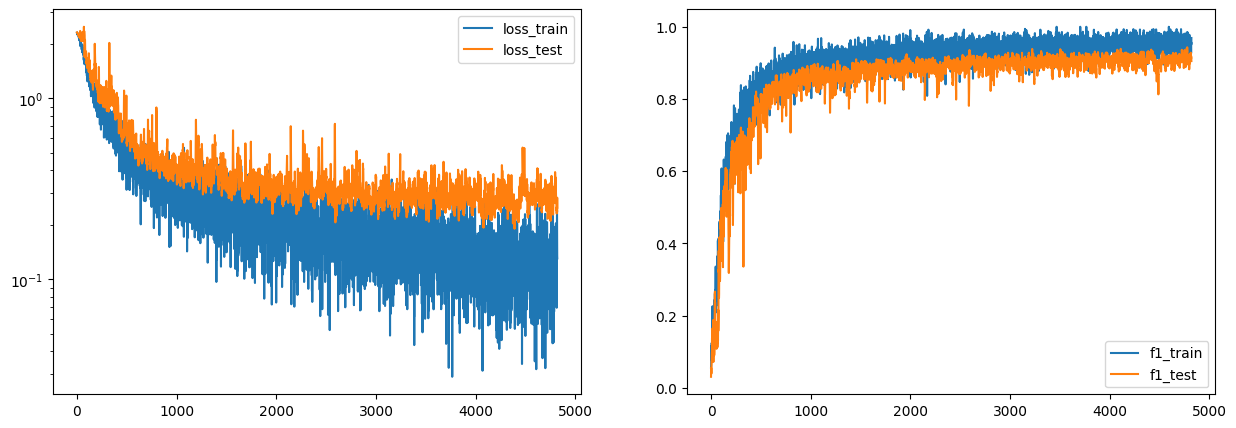

In [6]:
trainer_bin_op.visualize(filename=os.path.join(SIMPLECNN_DIR, "learning.jpg"))

## Рефакторинг готовой реализации

In [7]:
import torch
import torch.nn as nn

class BinWeightFn(torch.autograd.Function):
    @staticmethod
    def forward(ctx, weight: torch.Tensor):
        if weight.dim() == 4:
            # [out, in, kh, kw]
            negMean = weight.mean(dim=1, keepdim=True).mul(-1).expand_as(weight)
        elif weight.dim() == 2:
            # [out, in]
            negMean = weight.mean(dim=1, keepdim=True).mul(-1).expand_as(weight)

        w_centered = weight + negMean
        w_clamped  = w_centered.clamp_(-1.0, 1.0)

        if weight.dim() == 4:
            n = weight[0].numel()
            m = (w_clamped.norm(p=1, dim=3, keepdim=True)
                           .sum(2, keepdim=True)
                           .sum(1, keepdim=True)
                           .div(n))
        else:
            n = weight.size(1)
            m = w_clamped.norm(p=1, dim=1, keepdim=True).div(n)

        w_bin = w_clamped.sign()

        ctx.save_for_backward(w_clamped)
        ctx.n = n
        return w_bin, m

    @staticmethod
    def backward(ctx, grad_out: torch.Tensor, scale_grad:torch.Tensor):
        (w_clamped,) = ctx.saved_tensors
        n = ctx.n
        s = w_clamped.size()

        g = grad_out
        if w_clamped.dim() == 4:
            m = (w_clamped.norm(p=1, dim=3, keepdim=True)
                              .sum(2, keepdim=True)
                              .sum(1, keepdim=True)
                              .div(n)).expand(s)
        else:
            m = w_clamped.norm(p=1, dim=1, keepdim=True).div(n).expand(s)

        m = m.clone()
        m[w_clamped.lt(-1.0)] = 0
        m[w_clamped.gt( 1.0)] = 0

        grad = m * g

        m_add = w_clamped.sign() * g
        if w_clamped.dim() == 4:
            m_add = (m_add.sum(3, keepdim=True)
                           .sum(2, keepdim=True)
                           .sum(1, keepdim=True)
                           .div(n)
                           .expand(s))
        else:
            m_add = m_add.sum(1, keepdim=True).div(n).expand(s)

        m_add = m_add * w_clamped.sign()
        grad = (grad + m_add) * (1.0 - 1.0 / s[1]) * n
        #grad = grad * 1e9
        return grad
    
class BinActive(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        input = input.sign()
        return input
    
    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input.ge(1)] = 0
        grad_input[input.le(-1)] = 0
        return grad_input

class BinConv2d_Impl(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, x):
        x_bin = BinActive.apply(x)
        w_bin, scale = BinWeightFn.apply(self.weight)
        y = nn.functional.conv2d(x_bin, w_bin, self.bias,
                                 self.stride, self.padding,
                                 self.dilation, self.groups)
        return y * scale.view(1, -1, 1, 1)
    
class BinLinear_Impl(nn.Linear):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias=bias)

    def forward(self, x):
        x_bin = BinActive.apply(x)
        w_bin, scale = BinWeightFn.apply(self.weight)
        y = nn.functional.linear(x_bin, w_bin, self.bias)
        return y * scale.view(1, -1)

class BinConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, groups=1):
        super().__init__()
        self.bn = nn.BatchNorm2d(in_channels, eps=1e-4, momentum=0.1, affine=True)
        self.conv = BinConv2d_Impl(in_channels, out_channels, kernel_size=kernel_size,
                                   stride=stride, padding=padding, groups=groups)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        x = self.bn(x)
        x = self.conv(x)
        x = self.relu(x)
        return x

class BinLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        self.bn = nn.BatchNorm1d(in_features, eps=1e-4, momentum=0.1, affine=True)
        self.linear = BinLinear_Impl(in_features, out_features, bias=bias)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        x = self.bn(x)
        x = self.linear(x)
        x = self.relu(x)
        return x

class XNORSimpleCNN(torch.nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Conv2d(1, 64, (5,5), padding=2),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d((2,2), stride=2),
            BinConv2d(64, 96, (3,3), padding=1),
            torch.nn.MaxPool2d((2,2), stride=2),
            BinConv2d(96, 128, (3,3), padding=1),
            BinConv2d(128, 256, (3,3), padding=1),
            torch.nn.AdaptiveAvgPool2d((1,1)),
            torch.nn.Flatten()
        )
        self.fc = torch.nn.Sequential(
            BinLinear(256, 64),
            torch.nn.Linear(64, n_classes)
        )
        
    def forward(self, x):
        z = self.net(x)
        return self.fc(z)

In [8]:
SIMPLECNN_DIR = os.path.abspath('./models/XNORSimpleCNN')
SIMPLECNN_CHECKPOINTS_DIR = os.path.join(SIMPLECNN_DIR, 'checkpoints')
os.makedirs(SIMPLECNN_CHECKPOINTS_DIR, exist_ok=True)

model = trainer.fit(20, XNORSimpleCNN(class_counts), bs_test=512, save_path=SIMPLECNN_CHECKPOINTS_DIR)

100%|██████████| 241/241 [00:48<00:00,  4.98it/s]


epoch - 0: loss = 1.0004997253417969, f1 = 0.6449190586787823


100%|██████████| 241/241 [00:47<00:00,  5.03it/s]


epoch - 1: loss = 0.47086620330810547, f1 = 0.8492056019633916


100%|██████████| 241/241 [00:47<00:00,  5.08it/s]


epoch - 2: loss = 0.30979523062705994, f1 = 0.8979719240531475


100%|██████████| 241/241 [00:47<00:00,  5.07it/s]


epoch - 3: loss = 0.3447319269180298, f1 = 0.8886230088317417


100%|██████████| 241/241 [00:47<00:00,  5.06it/s]


epoch - 4: loss = 0.3108556866645813, f1 = 0.9030315956496798


100%|██████████| 241/241 [00:47<00:00,  5.07it/s]


epoch - 5: loss = 0.25964975357055664, f1 = 0.9061567705425174


100%|██████████| 241/241 [00:47<00:00,  5.08it/s]


epoch - 6: loss = 0.2911548912525177, f1 = 0.9157022651541403


100%|██████████| 241/241 [00:47<00:00,  5.08it/s]


epoch - 7: loss = 0.26354673504829407, f1 = 0.909852264989642


100%|██████████| 241/241 [00:47<00:00,  5.09it/s]


epoch - 8: loss = 0.22106900811195374, f1 = 0.928386850866549


100%|██████████| 241/241 [00:47<00:00,  5.03it/s]


epoch - 9: loss = 0.22911867499351501, f1 = 0.9281890090135507


100%|██████████| 241/241 [00:47<00:00,  5.03it/s]


epoch - 10: loss = 0.24422919750213623, f1 = 0.9242710752275751


100%|██████████| 241/241 [00:47<00:00,  5.07it/s]


epoch - 11: loss = 0.23343691229820251, f1 = 0.9253836156933779


100%|██████████| 241/241 [00:47<00:00,  5.08it/s]


epoch - 12: loss = 0.2852726876735687, f1 = 0.9161838950036355


100%|██████████| 241/241 [00:47<00:00,  5.08it/s]


epoch - 13: loss = 0.2489069402217865, f1 = 0.9271113726579465


100%|██████████| 241/241 [00:47<00:00,  5.08it/s]


epoch - 14: loss = 0.223557248711586, f1 = 0.9344016847749911


100%|██████████| 241/241 [00:47<00:00,  5.08it/s]


epoch - 15: loss = 0.2068246603012085, f1 = 0.9257671975364005


100%|██████████| 241/241 [00:47<00:00,  5.08it/s]


epoch - 16: loss = 0.24428215622901917, f1 = 0.9091014041572146


100%|██████████| 241/241 [00:47<00:00,  5.07it/s]


epoch - 17: loss = 0.15059635043144226, f1 = 0.95156021805421


100%|██████████| 241/241 [00:47<00:00,  5.07it/s]


epoch - 18: loss = 0.3147900104522705, f1 = 0.9113461774809298


100%|██████████| 241/241 [00:47<00:00,  5.07it/s]


epoch - 19: loss = 0.2009425014257431, f1 = 0.9376740196354284


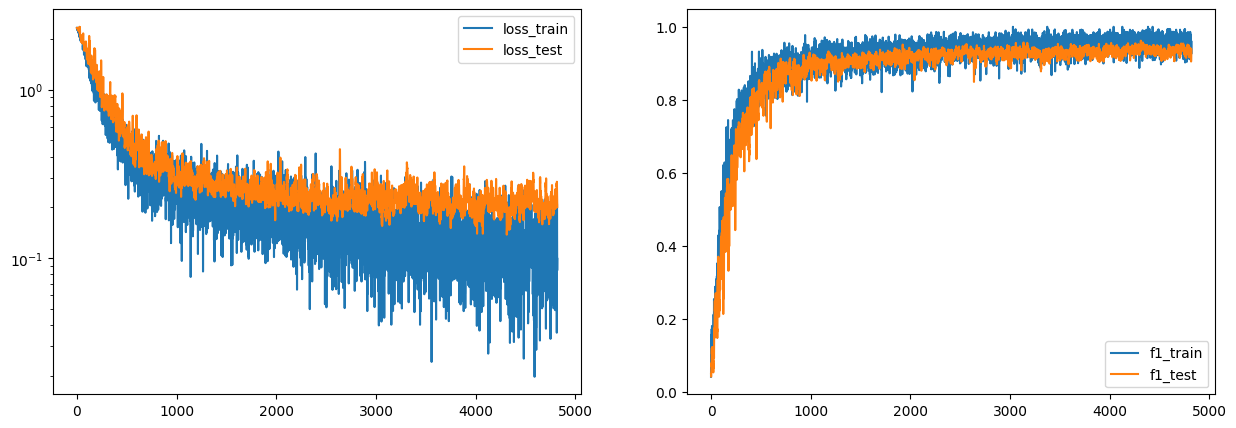

In [9]:
trainer.visualize(filename=os.path.join(SIMPLECNN_DIR, "learning.jpg"))

In [10]:
class BinConv2dWithoutRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, groups=1):
        super().__init__()
        self.bn = nn.BatchNorm2d(in_channels, eps=1e-4, momentum=0.1, affine=True)
        self.conv = BinConv2d_Impl(in_channels, out_channels, kernel_size=kernel_size,
                                   stride=stride, padding=padding, groups=groups)
    def forward(self, x):
        x = self.bn(x)
        x = self.conv(x)
        return x

class BinLinearWithoutRelu(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        self.bn = nn.BatchNorm1d(in_features, eps=1e-4, momentum=0.1, affine=True)
        self.linear = BinLinear_Impl(in_features, out_features, bias=bias)

    def forward(self, x):
        x = self.bn(x)
        x = self.linear(x)
        return x

class XNORSimpleCNNWithoutRelu(torch.nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Conv2d(1, 64, (5,5), padding=2),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d((2,2), stride=2),
            BinConv2dWithoutRelu(64, 96, (3,3), padding=1),
            torch.nn.MaxPool2d((2,2), stride=2),
            BinConv2dWithoutRelu(96, 128, (3,3), padding=1),
            BinConv2dWithoutRelu(128, 256, (3,3), padding=1),
            torch.nn.AdaptiveAvgPool2d((1,1)),
            torch.nn.Flatten()
        )
        self.fc = torch.nn.Sequential(
            BinLinearWithoutRelu(256, 64),
            torch.nn.Linear(64, n_classes)
        )
        
    def forward(self, x):
        z = self.net(x)
        return self.fc(z)

In [11]:
SIMPLECNN_DIR = os.path.abspath('./models/XNORSimpleCNNWithoutRelu')
SIMPLECNN_CHECKPOINTS_DIR = os.path.join(SIMPLECNN_DIR, 'checkpoints')
os.makedirs(SIMPLECNN_CHECKPOINTS_DIR, exist_ok=True)

model = trainer.fit(20, XNORSimpleCNNWithoutRelu(class_counts), bs_test=512, save_path=SIMPLECNN_CHECKPOINTS_DIR)

100%|██████████| 241/241 [00:45<00:00,  5.34it/s]


epoch - 0: loss = 1.8921613693237305, f1 = 0.28131011356541746


100%|██████████| 241/241 [00:44<00:00,  5.36it/s]


epoch - 1: loss = 1.3997999429702759, f1 = 0.4936472944519341


100%|██████████| 241/241 [00:45<00:00,  5.32it/s]


epoch - 2: loss = 2.468276023864746, f1 = 0.23097566942420017


100%|██████████| 241/241 [00:45<00:00,  5.33it/s]


epoch - 3: loss = 1.3159846067428589, f1 = 0.5903332374988915


100%|██████████| 241/241 [00:45<00:00,  5.33it/s]


epoch - 4: loss = 1.0492537021636963, f1 = 0.6752377872342101


100%|██████████| 241/241 [00:45<00:00,  5.35it/s]


epoch - 5: loss = 1.0130300521850586, f1 = 0.6536138649864239


100%|██████████| 241/241 [00:44<00:00,  5.37it/s]


epoch - 6: loss = 0.8991712331771851, f1 = 0.69328515758557


100%|██████████| 241/241 [00:44<00:00,  5.37it/s]


epoch - 7: loss = 1.3520029783248901, f1 = 0.5580098745875155


100%|██████████| 241/241 [00:44<00:00,  5.41it/s]


epoch - 8: loss = 0.8598432540893555, f1 = 0.7000653972514833


100%|██████████| 241/241 [00:44<00:00,  5.37it/s]


epoch - 9: loss = 0.8558725714683533, f1 = 0.703237885991317


100%|██████████| 241/241 [00:44<00:00,  5.38it/s]


epoch - 10: loss = 1.1339995861053467, f1 = 0.6260241113161168


100%|██████████| 241/241 [00:45<00:00,  5.34it/s]


epoch - 11: loss = 1.0380008220672607, f1 = 0.6455929071048795


100%|██████████| 241/241 [00:45<00:00,  5.32it/s]


epoch - 12: loss = 0.6647496223449707, f1 = 0.7667425837925637


100%|██████████| 241/241 [00:45<00:00,  5.33it/s]


epoch - 13: loss = 0.6930603981018066, f1 = 0.7494624404092614


100%|██████████| 241/241 [00:45<00:00,  5.33it/s]


epoch - 14: loss = 0.7438056468963623, f1 = 0.7397389311829031


100%|██████████| 241/241 [00:45<00:00,  5.32it/s]


epoch - 15: loss = 0.661811113357544, f1 = 0.8006511219591828


100%|██████████| 241/241 [00:45<00:00,  5.33it/s]


epoch - 16: loss = 0.9428106546401978, f1 = 0.7127710394685582


100%|██████████| 241/241 [00:45<00:00,  5.32it/s]


epoch - 17: loss = 1.0524497032165527, f1 = 0.6572561173322121


100%|██████████| 241/241 [00:45<00:00,  5.32it/s]


epoch - 18: loss = 0.7407817840576172, f1 = 0.7669371710224259


100%|██████████| 241/241 [00:45<00:00,  5.32it/s]


epoch - 19: loss = 0.7594980001449585, f1 = 0.7335228459857797


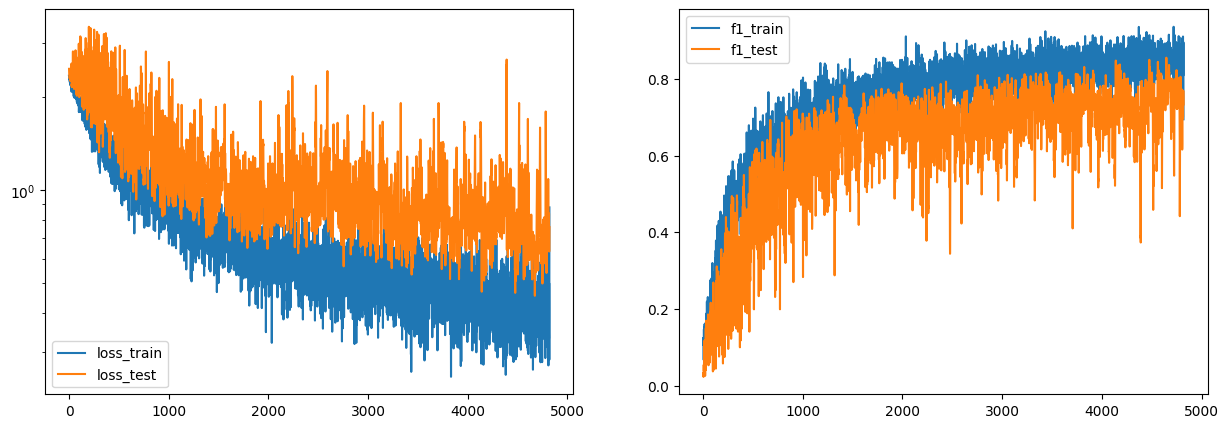

In [12]:
trainer.visualize(filename=os.path.join(SIMPLECNN_DIR, "learning.jpg"))

In [13]:
import torch.nn as nn
import torch
class Quantizer(nn.Module):
    def __init__(self, bit):

        super(Quantizer, self).__init__()
        self.bit = bit
        self.thd_neg = -(2 ** (bit - 1))
        self.thd_pos = 2 ** (bit - 1) - 1
        self.s = nn.Parameter(torch.ones(1))

    def init_from(self, x):
        s = (x.max() - x.min()) / (self.thd_pos - self.thd_neg )
        self.s = nn.Parameter(s)

    def skip_grad_scale(self,x, scale):
        y = x
        y_grad = x * scale
        return (y - y_grad).detach() + y_grad

    # LSQ pass
    def round_pass(self, x):
        y = x.round()
        y_grad = x
        return (y - y_grad).detach() + y_grad

    def forward(self, x):
        if self.bit >= 32:
            return x

        s_grad_scale = 1.0 / ((self.thd_pos * x.numel()) ** 0.5)  # emperial  !!! ???
        device = x.device

        s_scale = self.skip_grad_scale(self.s, s_grad_scale).to(device)

        x = x / (s_scale)
        x = torch.clamp(x, self.thd_neg, self.thd_pos)
        x = self.round_pass(x)
        
        return x*s_scale
    
class QAConv2d(nn.Module):
    def __init__(self, ch_in,ch_out, kernel=3, padding=0, stride=1):
        super(QAConv2d, self).__init__()
        self.bit = 2
        self.ch_in = ch_in
        self.ch_out = ch_out
        self.kernel = kernel
        self.padding = padding
        self.stride = stride
        self.conv = nn.Conv2d(ch_in, ch_out, kernel, stride, padding, bias=False)
        self.define_q_fucntions(self.bit)


    # can be used to modify bits during the training
    def define_q_fucntions(self, bit):
        self.quantizer_act = Quantizer(bit)
        self.quantizer_weight = Quantizer(bit)
        self.quantizer_weight.init_from(self.conv.weight)

    def forward(self, input_x):
        quantized_weight = self.quantizer_weight(self.conv.weight)
        quantized_act= self.quantizer_act(input_x)
        out = nn.functional.conv2d(quantized_act, quantized_weight, None, self.stride, self.padding)
        return out

class QALinear(nn.Module):
    def __init__(self, ch_in,ch_out):
        super(QALinear, self).__init__()
        self.bit = 2
        self.ch_in = ch_in
        self.ch_out = ch_out
        self.fc = nn.Linear(ch_in, ch_out, bias=True)
        self.define_q_fucntions(self.bit)


    # can be used to modify bits during the training
    def define_q_fucntions(self, bit):
        self.quantizer_act = Quantizer(bit)
        self.quantizer_weigh = Quantizer(bit)
        self.quantizer_weigh.init_from(self.fc.weight)

        self.quantizer_bias = Quantizer(bit)

    def forward(self, input_x):
        quantized_bias = self.quantizer_bias(self.fc.bias)
        quantized_weight = self.quantizer_weigh(self.fc.weight)
        quantized_act = self.quantizer_act(input_x)
        out = nn.functional.linear(quantized_act, quantized_weight, bias=quantized_bias)
        return out
    
class SimpleCNNQuintized(torch.nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Conv2d(1, 64, (5,5), padding=2),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d((2,2), stride=2),
            torch.nn.BatchNorm2d(64),
            QAConv2d(64, 96, (3,3), padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d((2,2), stride=2),
            torch.nn.BatchNorm2d(96),
            QAConv2d(96, 128, (3,3), padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d((2,2), stride=2),
            torch.nn.BatchNorm2d(128),
            QAConv2d(128, 256, (3,3), padding=1),
            torch.nn.ReLU(),
            torch.nn.AdaptiveAvgPool2d((1,1)),
            torch.nn.Flatten()
        )
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(256, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, n_classes)
        )
        
    def forward(self, x):
        z = self.net(x)
        return self.fc(z)

In [14]:
SIMPLECNN_DIR = os.path.abspath('./models/SimpleCNNQuintized')
SIMPLECNN_CHECKPOINTS_DIR = os.path.join(SIMPLECNN_DIR, 'checkpoints')
os.makedirs(SIMPLECNN_CHECKPOINTS_DIR, exist_ok=True)

model = trainer.fit(20, SimpleCNNQuintized(class_counts), bs_test=512, save_path=SIMPLECNN_CHECKPOINTS_DIR)

100%|██████████| 241/241 [00:44<00:00,  5.45it/s]


epoch - 0: loss = 1.1097228527069092, f1 = 0.5795177565875177


100%|██████████| 241/241 [00:43<00:00,  5.50it/s]


epoch - 1: loss = 0.9960435628890991, f1 = 0.6761964618511305


100%|██████████| 241/241 [00:43<00:00,  5.50it/s]


epoch - 2: loss = 0.7004286050796509, f1 = 0.7878933182565814


100%|██████████| 241/241 [00:43<00:00,  5.51it/s]


epoch - 3: loss = 0.5464783906936646, f1 = 0.8196336119413872


100%|██████████| 241/241 [00:43<00:00,  5.49it/s]


epoch - 4: loss = 0.5893034338951111, f1 = 0.811294014956865


100%|██████████| 241/241 [00:43<00:00,  5.49it/s]


epoch - 5: loss = 0.5935873985290527, f1 = 0.802748264970176


100%|██████████| 241/241 [00:43<00:00,  5.50it/s]


epoch - 6: loss = 0.753369152545929, f1 = 0.7668248421564294


100%|██████████| 241/241 [00:43<00:00,  5.50it/s]


epoch - 7: loss = 0.6333311796188354, f1 = 0.7875386864405598


100%|██████████| 241/241 [00:43<00:00,  5.49it/s]


epoch - 8: loss = 0.3422563672065735, f1 = 0.9027094920318248


100%|██████████| 241/241 [00:44<00:00,  5.39it/s]


epoch - 9: loss = 0.4351806044578552, f1 = 0.8561355096041716


100%|██████████| 241/241 [00:44<00:00,  5.40it/s]


epoch - 10: loss = 0.4235532581806183, f1 = 0.8791047349281577


100%|██████████| 241/241 [00:44<00:00,  5.40it/s]


epoch - 11: loss = 0.3560197353363037, f1 = 0.9009497913778063


100%|██████████| 241/241 [00:44<00:00,  5.41it/s]


epoch - 12: loss = 0.25635266304016113, f1 = 0.9164355891633139


100%|██████████| 241/241 [00:44<00:00,  5.41it/s]


epoch - 13: loss = 0.3416310250759125, f1 = 0.9132863682773606


100%|██████████| 241/241 [00:44<00:00,  5.41it/s]


epoch - 14: loss = 0.45438438653945923, f1 = 0.8649220153022961


100%|██████████| 241/241 [00:44<00:00,  5.41it/s]


epoch - 15: loss = 0.33537018299102783, f1 = 0.8979448478510077


100%|██████████| 241/241 [00:44<00:00,  5.41it/s]


epoch - 16: loss = 0.39169228076934814, f1 = 0.8911333774151883


100%|██████████| 241/241 [00:44<00:00,  5.43it/s]


epoch - 17: loss = 0.678389310836792, f1 = 0.8418562004277431


100%|██████████| 241/241 [00:44<00:00,  5.38it/s]


epoch - 18: loss = 0.25882989168167114, f1 = 0.9297061827950595


100%|██████████| 241/241 [00:44<00:00,  5.39it/s]


epoch - 19: loss = 0.4241520166397095, f1 = 0.867738630413889


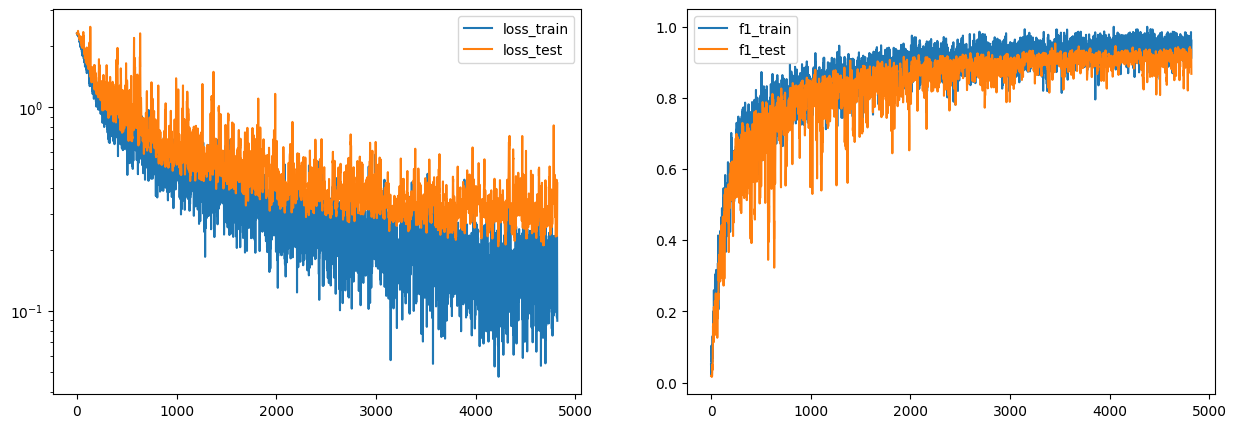

In [15]:
trainer.visualize(filename=os.path.join(SIMPLECNN_DIR, "learning.jpg"))